In [5]:
from tools.transcripts import *
from tools.psl import *
import pandas as pd
from tools.nameConversions import *

In [2]:
genomes = ("Chimp", "Gibbon", "Gorilla", "Orangutan", "Rhesus")
new_dir = '/public/groups/cgl/cat/primates_evan/work/transMap'
old_dir = '/public/groups/cgl/cat/primates_evan/original_primates/work/transMap/'


In [12]:
def load_metrics(genome, psl_dict):
    m = [[genome, strip_alignment_numbers(x.q_name), x.coverage, x.identity] for x in psl_dict.values()]
    return pd.DataFrame(m, columns=['Genome', 'TranscriptId', 'Coverage', 'Identity'])

gene_sets = []
for genome in genomes:
    new_psl = get_alignment_dict(f'{new_dir}/{genome}.filtered.psl')
    old_psl = get_alignment_dict(f'{old_dir}/{genome}.filtered.psl')
    new_metrics_df = load_metrics(genome, new_psl)
    old_metrics_df = load_metrics(genome, old_psl)
    merged = new_metrics_df.merge(old_metrics_df, on=['Genome', 'TranscriptId'], 
                                  suffixes=['_NewAssembly', '_OriginalAssembly'])
    gene_sets.append(merged)
df = pd.concat(gene_sets)

In [13]:
%matplotlib inline
import seaborn as sns

In [21]:
df['d(Identity)'] = 100.0 * (df['Identity_NewAssembly'] - df['Identity_OriginalAssembly'])
df['d(Coverage)'] = 100.0 * (df['Coverage_NewAssembly'] - df['Coverage_OriginalAssembly'])

In [22]:
m = df[['Genome', 'd(Identity)', 'd(Coverage)']].melt(id_vars=['Genome'])

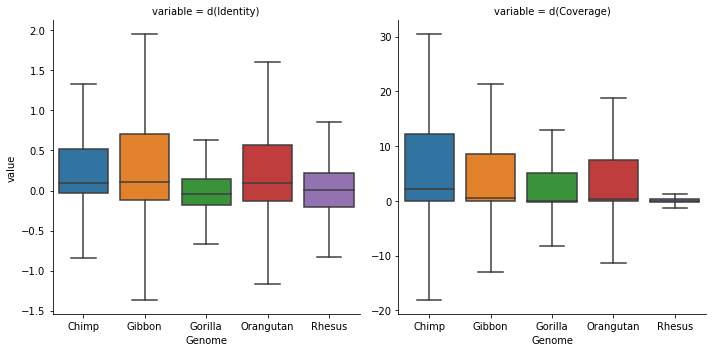

In [26]:
sns.catplot(data=m[m.value != 0], kind='box', x='Genome', y='value', col='variable', showfliers=False,
           sharey=False, order=genomes)

In [55]:
counts = []
for (genome, variable), d in m.groupby(['Genome', 'variable']):
    num_zero = len(d[d.value == 0])
    num_nonzero = len(d) - num_zero
    counts.append([genome, variable, num_zero, num_nonzero])
cdf = pd.DataFrame(counts, columns=['Genome', 'Metric', 'Unchanged', 'Changed'])
cdf = cdf.melt(id_vars=['Genome', 'Metric'])

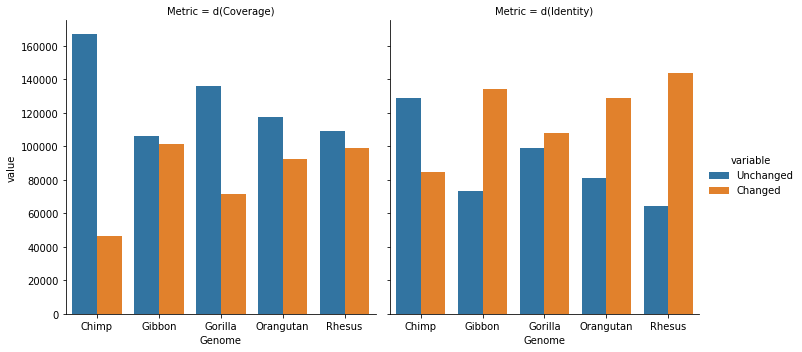

In [58]:
sns.catplot(data=cdf, hue='variable', y='value', x='Genome', col='Metric', kind='bar')